# Installation des packages

# Préparation des données

In [1]:
from scripts import data_collector as dc
from scripts import data_cleaner as dcl
from scripts import data_analysis as da
from scripts import data_visualization as dv


landlocked_url = "https://en.wikipedia.org/wiki/List_of_countries_by_length_of_coastline"
codesISO_url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

# Codes ISO-2 et ISO-3 relatifs aux pays

In [ ]:
codesISO_data = dc.get_ISOcodes(codesISO_url)
codesISO_data = dcl.clean_ISOData(codesISO_data)
codesISO_data

,Pays,ISO-2,ISO-3
0,Afghanistan,AF,AFG
1,Albania,AL,ALB
2,Algeria,DZ,DZA
3,Andorra,AD,AND
4,Angola,AO,AGO
...,...,...,...
188,Venezuela (Bolivarian Republic of),VE,VEN
189,Viet Nam[ak],VN,VNM
190,Yemen,YE,YEM
191,Zambia,ZM,ZMB


# PIB Réel

L'API permet de récupérer des données sur les pays via leurs codes ISO avec 2 lettres
Exemple : "FR" pour la France, "DE" pour l'Allemagne, "GB" pour le Royaume-Uni, etc.

In [8]:
wb = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-3"].tolist()
PIB_Reel_data = wb.get_indicator("PIB_reel", liste_pays, start=1990, end=2024)
PIB_Reel_data

,country,date,PIB
0,Afghanistan,2024,NaN
1,Afghanistan,2023,1.567265e+10
2,Afghanistan,2022,1.532523e+10
3,Afghanistan,2021,1.634520e+10
4,Afghanistan,2020,2.062196e+10
...,...,...,...
6750,Zimbabwe,1994,1.775729e+10
6751,Zimbabwe,1993,1.625602e+10
6752,Zimbabwe,1992,1.608687e+10
6753,Zimbabwe,1991,1.768090e+10


Il y a des problèmes avec les correspondances de noms entre les codes ISO et les noms des pays dans le dataframe PIB_reel_data
# Faire correspondre les noms des pays à la liste des ISO

In [37]:
PIB_countries = set(PIB_Reel_data["country"].unique())
ISO_countries = set(codesISO_data["Pays"].unique())

# Récupérer les pays avec un seul mot dans leur nom
single_word_countries = set(PIB_Reel_data[PIB_Reel_data['country'].str.split().str.len() == 1]['country'].tolist())
ISO_complicated_word_countries = ISO_countries - single_word_countries
potential_matching_complicated_word_countries = PIB_countries - single_word_countries

ISO_complicated_word_countries
potential_matching_complicated_word_countries

matching_dictionnary = {}

# Premier algorithme de matching basé sur les pays où les noms n'ont pas des caractères bizarres mais juste plusieurs mots
solved_ISO_complicated_word_countries = set()
solved_potential_matching_word_countries = set()

for iso_country in ISO_complicated_word_countries:
    for pib_country in potential_matching_complicated_word_countries:
        if iso_country in pib_country or pib_country in iso_country:
            matching_dictionnary[iso_country] = pib_country
            solved_ISO_complicated_word_countries.add(iso_country)
            solved_potential_matching_word_countries.add(pib_country)
            break

# Afficher les pays non résolus après le premier algorithme
unresolved_ISO_countries = ISO_complicated_word_countries - solved_ISO_complicated_word_countries
unresolved_potential_matching_countries = potential_matching_complicated_word_countries - solved_potential_matching_word_countries

unresolved_ISO_countries
unresolved_potential_matching_countries

{'Bahamas, The',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Gambia, The',
 'Iran, Islamic Rep.',
 "Korea, Dem. People's Rep.",
 'Korea, Rep.',
 'Kyrgyz Republic',
 'Lao PDR',
 'Micronesia, Fed. Sts.',
 'Slovak Republic',
 'St. Kitts and Nevis',
 'St. Lucia',
 'St. Vincent and the Grenadines',
 'Venezuela, RB'}

# Valeurs manquantes

In [4]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

Le dataframe contient des données temporelles relatives à 193 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.


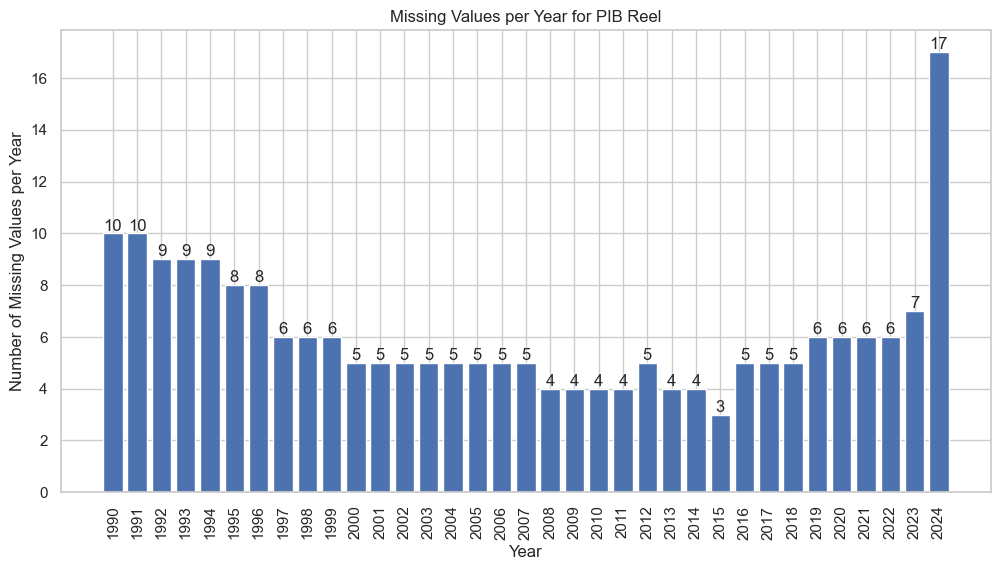

In [5]:
# Là on va checker d'où viennent les valeurs manquantes

# On va d'abord faire une analyse par date pour voir si c'est ça qui cause le problème

dv.plot_missing_values_per_year(PIB_Reel_data,"PIB")

In [6]:
# C'est bizarre qu'en 2024 il y ait plus de valeurs manquantes en 2024. Vérifions les pays dont les valeurs sont manquantes en 2024
NaN2024 = PIB_Reel_data[PIB_Reel_data["date"]==2024]["PIB"].isna()
NaN2024_countries = PIB_Reel_data[PIB_Reel_data["date"]==2024][NaN2024]
NaN2024_countries

# faire un commentaire
# Ce qu'on peut probablement faire c'est de l'imputation de données manquantes en utilisant la moyenne des valeurs des années précédentes pour chaque pays.
# Mais cela ne peut se faire que si on est dans des années qui sont intérieures c'est-à dire à partir de la première année omù il n'y a pas de valeur manquante

,country,date,PIB
0,Afghanistan,2024,NaN
910,Bhutan,2024,NaN
1435,Cuba,2024,NaN
1820,Eritrea,2024,NaN
3255,"Korea, Rep.",2024,NaN
3360,Lebanon,2024,NaN
3500,Liechtenstein,2024,NaN
3745,Monaco,2024,NaN
4830,Palau,2024,NaN
4935,"Korea, Dem. People's Rep.",2024,NaN


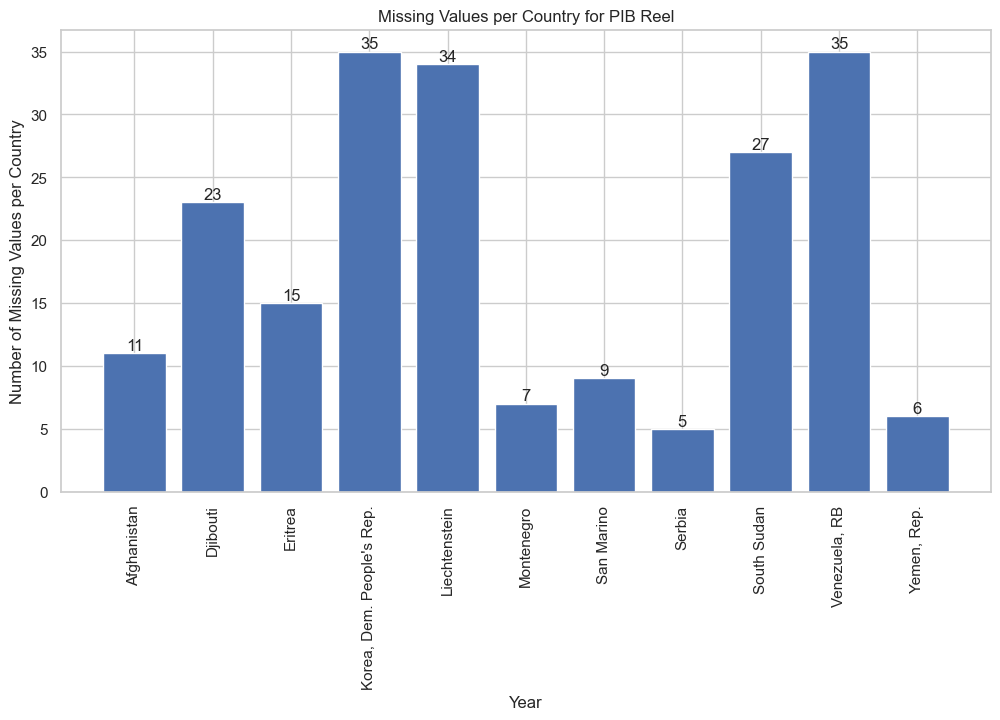

In [7]:
# Missing data per countries
# On va mettre un treshold à 5 valeurs pour tolérer 10% de données manquantes sinon on vire le pays.
countries_toRemove = dv.plot_missing_values_per_country(PIB_Reel_data,"PIB",treshold=0.1)

indexes_toRemove = []
for country in countries_toRemove:
    country_indexes = PIB_Reel_data[PIB_Reel_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

In [8]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

PIB_Reel_data_cleaned = PIB_Reel_data.drop(indexes_toRemove,axis='index')
PIB_Reel_data_cleaned.reset_index(drop=True,inplace=True)
da.check_missing_values(PIB_Reel_data_cleaned,"PIB")

Le dataframe contient des données temporelles relatives à 193 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 182 pays de 1990 à 2024.
Il y a 9 valeurs manquantes sur un total de 6370 dans la base de données. Soit un ratio de 0.14% de valeurs manquantes dans la base de données.


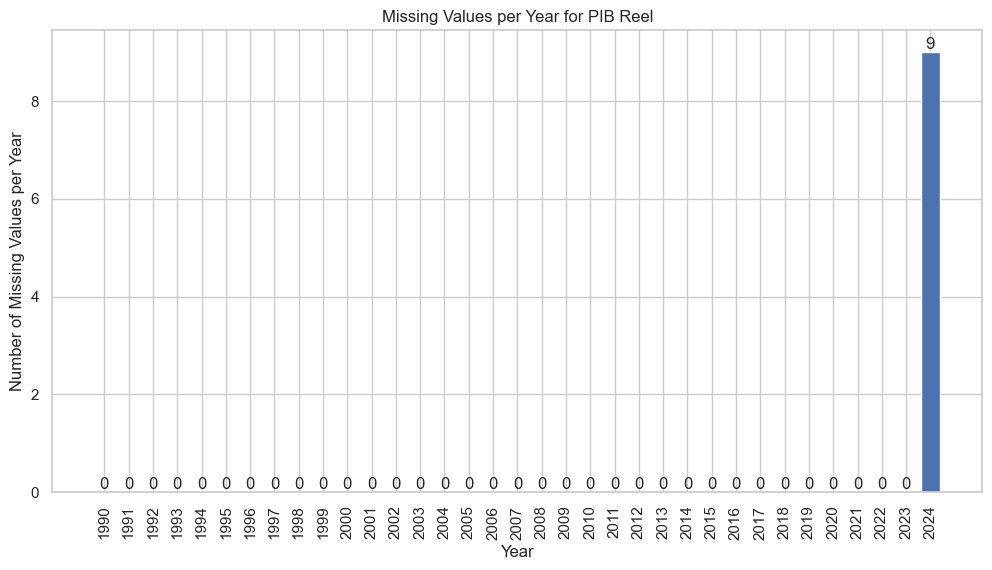

In [9]:
# On va voir où se situent les dernières valeurs manquantes
dv.plot_missing_values_per_year(PIB_Reel_data_cleaned,"PIB")

In [10]:
# La majeure partie des valeurs manquantes sont en 2024. On peut les imputer avec la moyenne des années précédentes.
PIB_Reel_data_final = da.impute_missing_values(PIB_Reel_data_cleaned,"PIB",method="mean")
da.check_missing_values(PIB_Reel_data_final,"PIB")

Le dataframe contient des données temporelles relatives à 182 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 6370 dans la base de données. Soit un ratio de 0.00% de valeurs manquantes dans la base de données.


## Description du PIB

## Evolution du PIB mondial

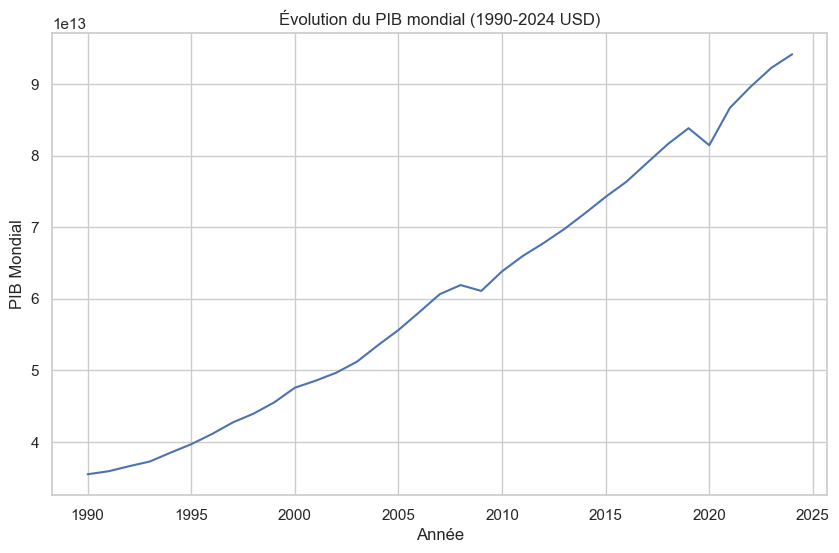

In [11]:
## Description du PIB
import matplotlib.pyplot as plt
dv.plot_world_PIB(PIB_Reel_data_final)

# Faire un commentaire

# Analyse des PIB de pays par quartiles 

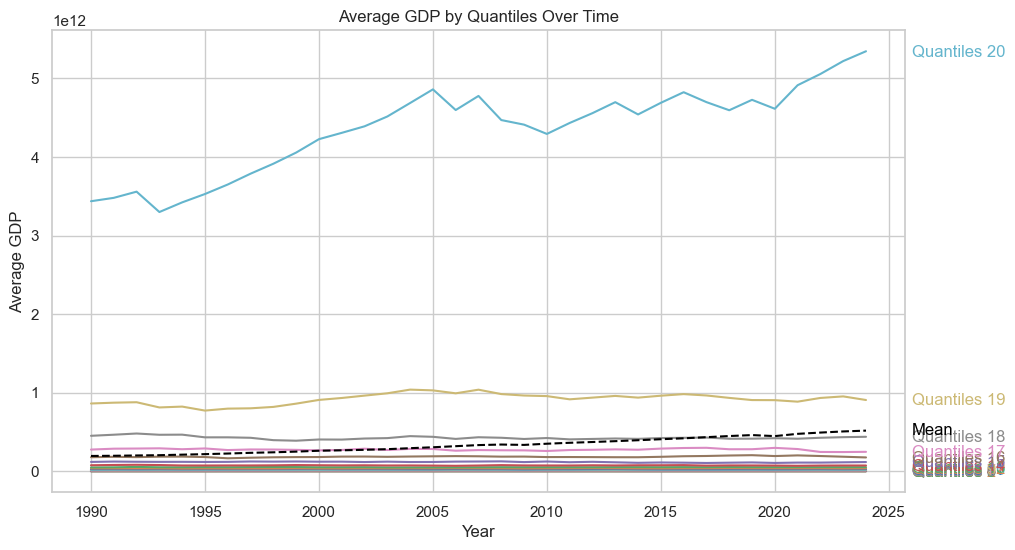

In [12]:
dv.plot_PIB_quantile(PIB_Reel_data_final)


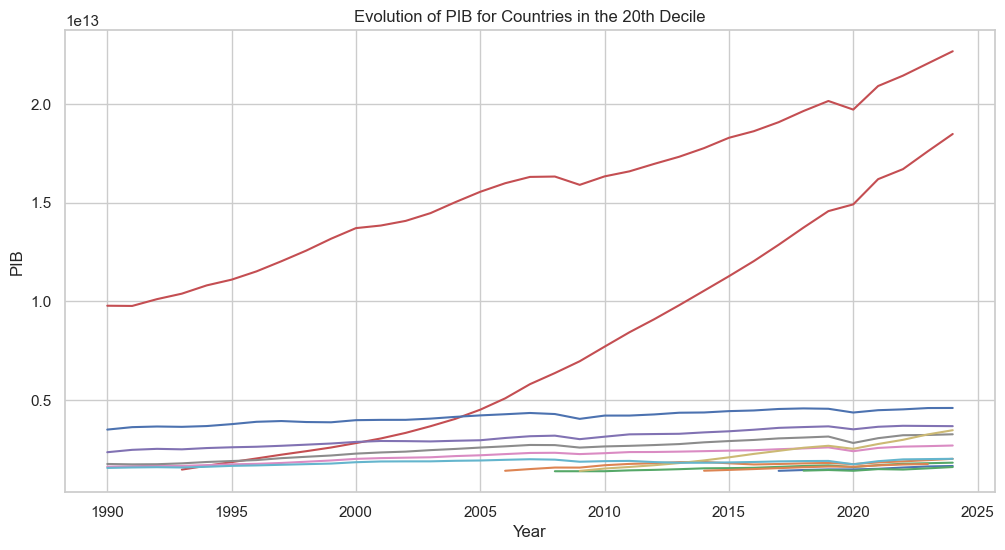

Countries in the 20th-decile: ['Australia' 'Brazil' 'Canada' 'China' 'Germany' 'Spain' 'France'
 'United Kingdom' 'India' 'Italy' 'Japan' 'Korea, Rep.'
 'Russian Federation' 'United States']


In [13]:
dv.plot_PIB_top_quantile_countries(PIB_Reel_data_final)

Faire un commentaire sur le fait que ce soient les pays les plus développés qui apparaissent dans ce graphique

# Ajout de la variable symbolisant la taille du pays dans l'économie mondiale

In [ ]:
dump = PIB_Reel_data_final.groupby(['country','date']).sum().apply(lambda x: 100*x/PIB_Reel_data_final.groupby("date")["PIB"].sum()).reset_index() # Associer à chaque pays son poids dans l'économie mondiale par année
dump.rename(columns={"PIB":"weightCountry"},inplace=True)
weightCountry = dump.groupby(['country']).mean()['weightCountry'].reset_index() 
weightCountry.rename(columns={"weightCountry":"avgWeightCountry"},inplace=True)

weightCountry.sort_values(by="avgWeightCountry",ascending=False)

,country,avgWeightCountry
175,United States,26.409606
34,China,10.542865
81,Japan,7.344783
61,Germany,5.376389
174,United Kingdom,4.343731
...,...,...
139,Sao Tome and Principe,0.000334
103,Marshall Islands,0.000311
85,Kiribati,0.000272
115,Nauru,0.000156


# Clustering

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np


# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
weightCountry["cluster"] = kmeans.fit_predict(weightCountry[["avgWeightCountry"]])

# Sort clusters by weight (so 2 = high, 1 = med, 0 = low)
cluster_order = weightCountry.groupby("cluster")["avgWeightCountry"].mean().sort_values().index
mapping = {cluster_order[0]: 0, cluster_order[1]: 1, cluster_order[2]: 2}
weightCountry["cluster"] = weightCountry["cluster"].map(mapping)



import plotly.express as px

fig = px.choropleth(
    weightCountry,
    locations="country",
    locationmode="country",
    color="cluster",
    color_continuous_scale=["blue", "orange", "red"],
    title="World Classification Map (0=Low, 1=Medium, 2=High)"
)
fig.show()


ValueError: 
    Invalid value of type 'builtins.str' received for the 'locationmode' property of choropleth
        Received value: 'country'

    The 'locationmode' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['ISO-3', 'USA-states', 'country names', 'geojson-id']